In [1]:
#imports 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
# classification of datas
# run this once at the start

temp = pd.read_csv("EEG_Measurements/book_english-english_translation_1.csv")
cols = temp.columns

metadata = pd.read_csv("metadata.csv")
everyone = []
english = [] # only english
spanish = []
french = []
german = []
other = []

participant_info = []
for index, row in metadata.iterrows():
    count = 0
    everyone.append(index + 1)
    if row["spanish"] == 1:
        spanish.append(index + 1)
        count += 1
    if row["french"] == 1:
        french.append(index + 1)
        count += 2
    if row["german"] == 1:
        german.append(index + 1)
        count += 4
    if row["other"] == 1:
        other.append(index + 1)
    if count == 0:
        english.append(index + 1)
    participant_info.append(count)
people = {"english": english, "spanish" : spanish, "french" : french, "german" : german, "other" : other, "everyone": everyone}

language = ["english", "spanish", "french", "german", "other", "everyone"]
relationships = ["translation", "unrelated"]
#variable of each language contains anyone who can speak that language(except english)
#In order to get people that can't speak spanish, we can do (english + french + german + other and delete repeats) or (everyone - spanish)

folder_path = "EEG_Measurements"
files = os.listdir(folder_path)



In [3]:
# Independent Variables

# what files we want to use
# language = ["english", "spanish", "french", "german", "other", "everyone"]
prime_word = language[0]
target_word = language[0]

# relationships = ["translation", "unrelated"]
relation = relationships[1]

#which group of individuals to look at
control_group = language[0]
experiment_group = language[1]

control = people[control_group]
# # If experiment is for one specific language group, use first statement. 
# # If experiment is for everyone except one specific language group, use second statment
experiment = people[experiment_group]
# experiment = [individual for individual in people["everyone"] if individual not in control]

# What electronodes to look at
# cols = 
# 'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
interested_cols = ['C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']


In [5]:
# selecting files wanted and appending to appropriate list

file_for_control = []
file_for_experiment = []

for file in files:
    if f"{prime_word}-{target_word}_{relation}" in file: 
        participant_num = int(file.split("_")[3][:-4])
        if participant_num in control:
            file_for_control.append(file)
        elif participant_num in experiment:
            file_for_experiment.append(file)



In [6]:
# creating df that averages all the control group data at interested electronode

control_df = pd.DataFrame()

for file in file_for_control:
    for col in interested_cols:
        df = pd.read_csv("EEG_Measurements/" + file)[col]
        control_df = pd.concat([control_df, df],axis = 1)

control_df = control_df.sum(axis = 1)/control_df.shape[1]

# baselining the graph to 0
control_baseline = control_df[0:25].mean()
control_df = control_df - control_baseline

In [7]:
# creating df that averages all the control group data at interested electronode

experiment_df = pd.DataFrame()
for file in file_for_experiment:
    for col in interested_cols:
        df = pd.read_csv("EEG_Measurements/" + file)[col]
        experiment_df = pd.concat([experiment_df, df], axis = 1)

experiment_df = experiment_df.sum(axis = 1)/experiment_df.shape[1]

experiment_baseline = experiment_df[0:25].mean()
experiment_df = experiment_df - experiment_baseline

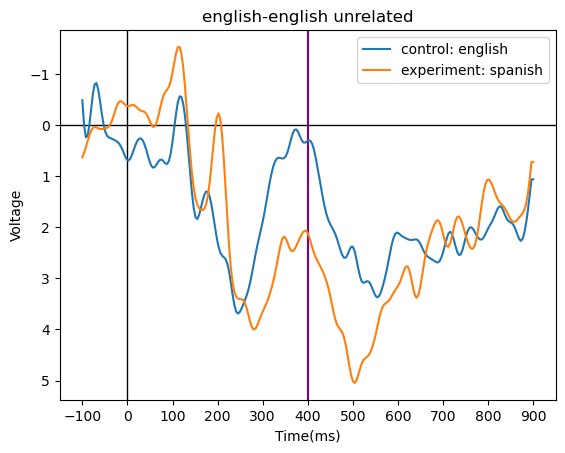

In [8]:
x_transformed = np.linspace(-100, 900, 256)

plt.axhline(y=0, color='black', linewidth=1)  # Horizontal line (x-axis)
plt.axvline(x=0, color='black', linewidth=1)  # Vertical line (y-axis)
plt.axvline(x = 400, color = 'purple')
plt.plot(x_transformed, control_df, label = f"control: {control_group}")
plt.plot(x_transformed, experiment_df, label = f"experiment: {experiment_group}")
# blue = control = english speaker
# red = experiment = spanish speaker
plt.title(f"{prime_word}-{target_word} {relation}")
plt.xlabel("Time(ms)")
xticks = [-100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900]  
plt.xticks(xticks)
plt.ylabel("Voltage")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [274]:

def DQP (data):
    """
    Input : list of EEG Data that contains 64 lines (250-500ms) that has been baselined to average of -100ms to 0ms

    Function : Perform DQP to find seven textural feature of EEG

    Output : 7 feature vectors :  
    """
    # S1
    
    db = [[0 for i in range(36)] for j in range(len(data) - 35)]
    for j in range(len(data) - 36):
        for i in range(36):
            db[j][i] = data[j + i]

    Up = []
    Middle = []
    Low = []
    features = [0,0,0,0,0,0,0]

    for current_block in range(len(data) - 35):
        # S2
        lat = []
        for k in range(4):
            temp = []
            for l in range(9):
                temp.append(db[current_block][9*k+l])
            lat.append(temp)

        # S3
        path = []
        for l in range(9):

            column_values = [row[l] for row in lat]
        
            # Find the maximum value in the column
            max_value = max(column_values)
            
            # Find the index of the maximum value in the column
            max_index = column_values.index(max_value)
            
            # Append the index to the result list
            path.append(max_index + l*4)
        
        # S4
        diff = []
        bitU = []
        bitM = []
        bitL = []
        for t in range(1,8):
            diff.append(path[t+1] - path[t])
            bitU.append(int(diff[t - 1]/4))
            bitM.append(int((diff[t - 1] - 4*bitU[t-1])/2))
            bitL.append(int(diff[t - 1]%2))

        #S5        
        Up.append(int(''.join(map(str, bitU)), 2))
        Middle.append(int(''.join(map(str, bitM)), 2))
        Low.append(int(''.join(map(str, bitL)), 2))

    # S7
    features[0], _ = np.histogram(Up, bins = 256, range = (0,256))
    features[1], _ = np.histogram(Middle, bins = 256, range = (0,256))
    features[2], _ = np.histogram(Low, bins = 256, range = (0,256))

    # S8
    features[3] = features[0] + features[1]
    features[4] = features[0] + features[2]
    features[5] = features[1] + features[2]

    features[6] = features[0]+features[1]+features[2]

    return features





In [276]:
           
from scipy.stats import kurtosis, skew, entropy
from scipy.signal import welch
import statistics

def calculate_features(data):
    """
    Calculate various statistical features from the input data and return them as a list.

    Parameters:
        data (array-like): Input data array.

    Returns:
        list: A list containing the calculated features in a specified order.
    """

# Ensure data is a NumPy array
    data = np.array(data)

    # Initialize a list to store features
    features = []

    # Calculate features
    features.append(np.max(data))  # Maximum
    features.append(np.mean(data))  # Average
    features.append(np.median(data))  # Median
    features.append(np.var(data))  # Variance
    features.append(np.std(data))  # Standard Deviation
    features.append(np.min(data))  # Minimum
    features.append(np.max(data) - np.min(data))  # Range
    features.append(np.sum(data**2))  # Energy
    features.append(np.sqrt(np.mean(data**2)))  # Root Mean Square
    features.append(entropy(np.histogram(data, bins=10, density=True)[0] + 1e-10))  # Shannon Entropy
    features.append(skew(data))  # Skewness

    mode = statistics.mode(data)
    features.append(mode)

    # Ratios
    avg = np.mean(data)
    variance = np.var(data)
    std_dev = np.std(data)

    features.append(features[0] / avg if avg != 0 else np.inf)  # Ratio of Maximum and Average
    features.append(features[0] / features[2] if features[2] != 0 else np.inf)  # Ratio of Maximum and Median
    features.append(features[0] / variance if variance != 0 else np.inf)  # Ratio of Maximum and Variance
    features.append(features[0] / std_dev if std_dev != 0 else np.inf)  # Ratio of Maximum and Standard Deviation
    features.append(features[0] / mode if mode != 0 else np.inf)  # Ratio of Maximum and Mode
    features.append(avg / mode if mode != 0 else np.inf)  # Ratio of Mean and Mode
    features.append(kurtosis(data, fisher=True))  # Fisher’s Kurtosis

    # Ratio of Skewness and Kurtosis
    features.append(features[10] / features[18] if features[18] != 0 else np.inf)  # Ratio of Skewness and Fischer’s Kurtosis

    # Power Spectral Density (PSD)
    freqs, psd = welch(data)
    features.append(np.mean(freqs))
    
    # Band power for specific frequency bands
    delta_power = np.trapz(psd[(freqs >= 0.5) & (freqs < 4)])
    theta_power = np.trapz(psd[(freqs >= 4) & (freqs < 8)])
    alpha_power = np.trapz(psd[(freqs >= 8) & (freqs < 12)])
    beta_power = np.trapz(psd[(freqs >= 12) & (freqs < 30)])
    features.append(delta_power)
    features.append(theta_power)
    features.append(alpha_power)
    features.append(beta_power)

    return features


In [238]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis

def apply_nca(feature_matrix, labels, test_size=0.2, random_state=42, n_neighbors=5, n_components=2):
    """
    Applies Neighborhood Component Analysis (NCA) for feature selection and evaluates a KNN classifier.
    
    Parameters:
    - feature_matrix: ndarray or DataFrame, shape (n_samples, n_features)
        The input features to be analyzed.
    - labels: array-like, shape (n_samples,)
        The target labels for classification.
    - test_size: float, optional (default=0.2)
        The proportion of the dataset to include in the test split.
    - random_state: int, optional (default=42)
        Random seed for reproducibility.
    - n_neighbors: int, optional (default=5)
        The number of neighbors to use for the KNN classifier.
    - n_components: int, optional (default=2)
        The number of components for NCA.

    Returns:
    - X_transformed: ndarray, shape (n_samples, n_components)
        The transformed feature matrix after applying NCA.
    - accuracy: float
        The accuracy of the KNN classifier on the test set.
    - feature_importance: ndarray
        The importance of each feature based on NCA.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size=test_size, random_state=random_state)

    # Initialize NCA
    nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=random_state)

    # Fit NCA
    nca.fit(X_train, y_train)

    # Transform the training and test data
    X_train_nca = nca.transform(X_train)
    X_test_nca = nca.transform(X_test)

    # Train a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_nca, y_train)

    # Evaluate the classifier
    accuracy = knn.score(X_test_nca, y_test)

    # Get feature importance
    feature_importance = nca.components_

    return X_train_nca, accuracy, feature_importance


In [280]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Initialize lists to collect data and labels
data_frames = []
labels = []

all_files = os.listdir(folder_path)
files = [file for file in all_files if "spanish" in file]
# files = all_files


# Function to process each file
def process_file(file):
    baseline_df = pd.read_csv("EEG_Measurements/" + file, usecols=interested_cols, nrows = 25) # df of file for -100ms to 0ms
    data_df = pd.read_csv("EEG_Measurements/" + file, usecols=interested_cols, skiprows = [i for i in range(1, 90) ], nrows = 64) # df of file for 250ms to 500ms
    participant_num = int(file.split("_")[3][:-4])
    label = (participant_num in spanish) & 1
    
    data_df_sum = data_df.sum(axis = 1)/len(interested_cols)
    baseline_df_sum = baseline_df.sum(axis = 1)/len(interested_cols)

    data_df_sum = data_df_sum - baseline_df_sum.mean()

    features = calculate_features(data_df_sum)

    return data_df_sum, [label]



# Use ThreadPoolExecutor to read files in parallel
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, files))

# Collect DataFrames and labels
for df, label in results:
    data_frames.append(df)
    labels.extend(label)




c:\Users\choiy\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
C:\Users\choiy\AppData\Local\Temp\ipykernel_412\59715401.py:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_power = np.trapz(psd[(freqs >= 0.5) & (freqs < 4)])
C:\Users\choiy\AppData\Local\Temp\ipykernel_412\59715401.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  theta_power = np.trapz(psd[(freqs >= 4) & (freqs < 8)])
C:\Users\choiy\AppData\Local\Temp\ipykernel_412\59715401.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  alpha_power = np.tr

In [ ]:
# # AI Creation 

import pywt


data_frames


def FeatureExtraction(EEG):
    # Apply MDWT to decompose the channel into low-pass and high-pass wavelet bands
    w_i = []
    channel = np.array(EEG)
    w_i.append(channel)
    for i in range(0, 4):
        l,h = pywt.dwt(w_i[i],'db4')
        w_i.append(np.array(l))
    


    feature_matrix = []
    #For each low-pass wavelet band:
    for l_w in w_i:
        textural_features = DQP(l_w[0])
        features_raw = calculate_features(l_w[0])
        features_abs = calculate_features(abs(l_w[0]))
        features = textural_features + features_raw + features_abs
        feature_matrix.append(features)
    return feature_matrix

def FeatureSelection(feature_matrix, labels):
    selected_feature = []
    NCA_selected_feature = apply_nca(selected_feature, labels)

#     return 
 
FeatureExtraction(data_frames)


0
[[ 6.74481    6.25731    5.927935   5.88356    6.190435   6.7688725
   7.38631    7.7532475  7.6674975  7.1251225  6.31806    5.51006
   4.864685   4.3579975  3.8474975  3.2479975  2.666685   2.38456
   2.6889975  3.6819975  5.2086225  6.9587475  8.65881   10.206435
  11.661935  13.141935  14.7121225 16.3442475 17.92006   19.25456
  20.1221225 20.2881225 19.549935  17.811435  15.1803725 12.0242475
   8.906685   6.41406    4.9684975  4.7157475  5.516435   7.0251225
   8.8239975 10.5771225 12.126685  13.48206   14.699185  15.74006
  16.40606   16.3997475 15.475435  13.6028725 11.0692475  8.4386225
   6.362185   5.326435   5.485935   6.658935   8.4449975 10.3783725
  12.054685  13.208185  13.7302475 13.657185 ]]
1
[[ 8.72371106  8.41592475  9.54767208  8.81370155  8.3217616   9.6427842
  10.983936   10.00817918  7.78444661  6.19661895  4.53198154  3.32932995
   5.28232727  9.88614998 14.41797975 18.59417653 23.15586408 27.28392381
  28.73032484 25.1221986  16.85538693  9.00250524  6.730

[[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 8, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([7, 4, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,

In [281]:
# Concatenate the dataframes into one DataFrame
X = pd.DataFrame(data_frames)

# Create a Series from the labels
y = pd.Series(labels)

print("X shape:", X.shape)  # Should be (2560, 16)
print("y shape:", y.shape)

X

X shape: (5979, 64)
y shape: (5979,)


0          1          2          3          4          5   \
0      4.578855   5.534230   6.067980   6.010855   5.284918   4.023793   
1     10.046655  10.201655  10.262093  10.123030   9.592155   8.554030   
2      7.349108   8.078045   9.255420  10.806857  12.492732  13.945608   
3     -3.650148  -4.183085  -3.524773  -1.957835  -0.037898   1.424415   
4     16.106785  15.749660  15.866160  16.538097  17.598973  18.670660   
...         ...        ...        ...        ...        ...        ...   
5974   0.335985   4.049985   7.004797   8.037297   6.695922   3.436985   
5975   9.401845  10.979157  12.107845  12.857657  13.341658  13.670845   
5976   0.665105   0.586418   1.524355   3.262668   5.295730   7.004668   
5977  -7.325530  -9.237155 -10.869718 -11.896467 -12.075905 -11.377343   
5978  16.744605  17.748480  18.851668  19.810168  20.560105  21.191293   

             6          7          8          9   ...         54         55  \
0      2.650605   1.813543   2.143480   3.916605  ...   6.784793   5.529792   
1      7.088280   5.462718   4.003717   2.921780  ...  20.624405  19.646030   
2     14.803045  14.866483  14.179108  12.972857  ...   4.517108   6.343920   
3      1.561228  -0.166148  -3.610210  -7.914398  ...  10.632415  10.666853   
4     19.266160  18.930347  17.379160  14.609785  ...  27.380410  27.956785   
...         ...        ...        ...        ...  ...        ...        ...   
5974  -0.578828  -4.016390  -5.936953  -6.088202  ... -10.640515  -9.480703   
5975  13.926908  14.124970  14.194282  14.022970  ...   3.810408   7.303783   
5976   7.887105   7.738730   6.699230   5.140105  ...  -9.954645 -14.326020   
5977 -10.015217  -8.373405  -6.846405  -5.680343  ...   7.035907   9.560408   
5978  21.799855  22.344542  22.616230  22.344105  ...  14.456793  15.919168   

             56         57         58         59         60         61  \
0      3.027918  -0.043645  -2.941833  -5.068145  -6.067020  -5.858520   
1     18.583405  17.803718  17.483593  17.602342  17.999030  18.449655   
2      8.147670   9.329733   9.537482   8.802983   7.489483   6.094108   
3     11.157103  12.876540  16.183728  20.799102  25.809040  29.960102   
4     27.516972  26.005848  23.657410  20.889098  18.128785  15.671160   
...         ...        ...        ...        ...        ...        ...   
5974  -7.871390  -6.379140  -5.526265  -5.549640  -6.353827  -7.640578   
5975  10.731595  13.689657  15.953220  17.453907  18.274783  18.667658   
5976 -16.631208 -16.587083 -14.809145 -12.505145 -10.966645 -11.067020   
5977  10.445220   9.613720   7.497595   4.809845   2.256032   0.326470   
5978  16.839793  17.010730  16.467543  15.484980  14.456980  13.721418   

             62         63  
0     -4.675957  -3.084333  
1     18.734968  18.676405  
2      5.028170   4.493733  
3     32.162978  31.937540  
4     13.625098  11.957660  
...         ...        ...  
5974  -9.080515 -10.400327  
5975  18.997970  19.578157  
5976 -12.959832 -16.079020  
5977  -0.766280  -1.043218  
5978  13.427355  13.499293  

[5979 rows x 64 columns]

In [289]:
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)    # Set random state for reproducibility

# smote = SMOTE(random_state=42)    # Set random state for reproducibility)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

# Initialize the XGBRFClassifier
model = xgb.XGBRFClassifier(
    n_estimators=247,  # Start with a lower number of trees
    max_depth=19,       # Use a reasonable maximum depth
    learning_rate=0.06, # A lower learning rate for more stable training
    subsample=0.7,     # Increase the subsample ratio slightly
    colsample_bynode=0.7,  # Adjust as needed
    random_state=42    # Set random state for reproducibility
)


# model = lgb.LGBMClassifier(
#     n_estimators=250,       # Number of boosting rounds
#     max_depth=10,           # Maximum depth of trees
#     learning_rate=0.07,     # Learning rate
#     subsample=0.8,          # Subsample ratio of the training instances
#     colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
#     random_state=42 ,        # Seed for reproducibility
#     verbose=-1  # Disable output
# )
model.fit(X_train_resampled, y_train_resampled)


scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

# Make predictions and evaluate
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Cross-Validation Accuracy Scores: [0.71288515 0.75560224 0.77785564 0.76664331 0.78626489]
Mean Accuracy: 0.759850247036446
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       905
           1       0.30      0.10      0.15       291

    accuracy                           0.72      1196
   macro avg       0.53      0.51      0.49      1196
weighted avg       0.65      0.72      0.67      1196

[[835  70]
 [261  30]]


In [ ]:
# precision    recall  f1-score   support

#            0       0.78      0.77      0.78       905
#            1       0.32      0.33      0.32       291

#     accuracy                           0.67      1196
#    macro avg       0.55      0.55      0.55      1196
# weighted avg       0.67      0.67      0.67      1196

# [[701 204]
#  [196  95]]